# Read a File and Translate Using Langchain Agents

## What You'll Learn
In this tutorial, you will learn how to:
- Install and import necessary libraries.
- Configure and set up a language model.
- Define and manage agent states.
- Implement asynchronous agents for reading and translating text.
- Create and compile a state graph.
- Execute the workflow and observe state changes.

## Basic Concepts
We'll be using Langchain agents to read a file and translate its content. The agents will handle the text reading and translation asynchronously.

## 1. Installation of Required Libraries

In this cell, we check if the termcolor and langgraph libraries are already installed. If they are not, we install them using `%pip install`. These libraries are needed for colored terminal outputs and to create and manage the state graph, respectively.

In [66]:
# Install termcolor for colored terminal outputs
%pip install termcolor langgraph

Note: you may need to restart the kernel to use updated packages.


## 2. Importing Necessary Libraries

Here, we import all the libraries and modules we need for this notebook:

In [67]:
from langgraph.graph.message import add_messages
from typing import TypedDict, Annotated, List
from termcolor import colored
from datetime import datetime, timezone
import random
import time
import asyncio
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
import json
import requests

## 3. Model Configuration

In this section, we set up the configuration for the Ollama model.

### Setting Up the Ollama Model

The `setup_ollama_model` function configures the model settings, including the endpoint, model name, system prompt, and other parameters. This setup is essential for initializing the model with the correct configuration, ensuring it can process queries and utilize the tools effectively.

In [68]:
def setup_ollama_model(model, temperature=0, stop=None):
    """
    Sets up the Ollama model configuration.

    Parameters:
    model (str): The name of the model to use.
    temperature (float): The temperature setting for the model.
    stop (str): The stop token for the model.

    Returns:
    dict: Configuration for the Ollama model.
    """
    return {
        "model_endpoint": "http://localhost:11434/api/generate",
        "model": model,
        "temperature": temperature,
        "headers": {"Content-Type": "application/json"},
        "stop": stop,
    }


# Example configuration
ollama_config = setup_ollama_model(model="llama3:instruct")

## 4. Defining Agent Graph State

We define the state object for the agent graph and functions to retrieve and update the state.

In [69]:
# Define the state object for the agent graph
class AgentGraphState(TypedDict):
    start_chain: Annotated[list, add_messages]
    text_response: Annotated[list, add_messages]
    translate_response: Annotated[list, add_messages]
    end_chain: Annotated[list, add_messages]

# Function to retrieve specific parts of the agent state
def get_agent_graph_state(state: AgentGraphState, state_key: str):
    return state.get(state_key, None) if state_key in state else None

# New method to return all entries from a list in the graph state
def get_all_entries_from_state(state: AgentGraphState, state_key: str):
    return state.get(state_key, []) if state_key in state else []

## 5. Utility Functions

### Getting Current UTC DateTime

We create a function to get the current UTC date and time.

In [70]:
def get_current_utc_datetime():
    now_utc = datetime.now(timezone.utc)
    return now_utc.strftime("%Y-%m-%d %H:%M:%S.%f UTC")[:-3]

## 6. Asynchronous Agents

In [71]:
class AsyncAgent:

    def __init__(self, state: AgentGraphState, role: str, model_config: dict):
        self.state = state
        self.role = role
        self.range = random.randint(5, 10)
        self.sleep_time = random.randint(1, 10)
        self.model_endpoint = model_config.get("model_endpoint")
        self.model_name = model_config.get("model")
        self.temperature = model_config.get("temperature", 0)  # Default temperature is 0
        self.headers = model_config.get("headers", {"Content-Type": "application/json"})
        self.stop = model_config.get("stop")

    def update_state(self, key: str, value: any):
        if key in self.state:
            self.state[key].append(value)
        else:
            print(
                colored(
                    f"Warning: Attempting to update a non-existing state key '{key}'.",
                    "red",
                )
            )

## Translate Agent

The `TranslateAgent` class translates the text and updates the state.

In [72]:
class TextAgent(AsyncAgent):

    async def invoke(self, text_file: str):
        with open(text_file) as f:
            for line in f:
                time.sleep(2)
                timestamp = get_current_utc_datetime()
                print(
                    colored(
                        f"{timestamp} TEXT_AGENT - Reading line -> {line}", "yellow"
                    )
                )
                self.update_state("text_response", line)
                yield self.state

        print(colored(f"\nTEXT_AGENT : END CHAIN\n", "red"))
        self.state["end_chain"].append("END")
        yield self.state

### Translate Agent

The `TranslateAgent` class translates the text and updates the state.

In [73]:
# Template for guiding the real-time event translation agent
translate_prompt_template = """
You are a real-time event translation agent working like a closed captioning system. Your task is to translate chunks of text received as input in real-time, ensuring the translation is accurate and timely. You must decide whether the current input is sufficient to form a complete sentence or if you need to wait for more words before translating.

## Output Language:
PORTUGUESE

## Current date and time:
{datetime}

## Accumulated Text
This variable contains all the text captured up to this point. Use this to accumulate text until a complete sentence is formed.
{accumulated_text}

## Translated Text
This variable contains all the translated text up to this point.
{translated_text}

**Important**:
1. When you receive a chunk of text, analyze if it, combined with the accumulated text, forms a complete sentence.
2. If it is a complete sentence, provide the translation immediately.
3. If it is not a complete sentence, hold the accumulated text until more words are received.
4. Handle punctuation carefully to ensure sentences are translated accurately.
5. Avoid translating partial sentences unless they form a meaningful phrase.

Your response must take the following JSON format:

    "translated_sentence": "The translated sentence if it is good enough",
    "waiting_for_more_text": true or false

**Examples**:

**Complete Sentence Example**:
- Input: "Hello world!"
- Translated Sentence: "Olá, mundo!"
- Waiting for More Text: false

- Input: "Hello, how are you?"
- Translated Sentence: "Olá, como está?"
- Waiting for More Text: false

**Incomplete Sentence Example**:
- Input: "Hello, how"
- Translated Sentence: ""
- Waiting for More Text: true

**Completing the Sentence Example**:
- Input: "are you?"
- Translated Sentence: "Olá, como está?"
- Waiting for More Text: false

**Input with Incomplete and Complete Sentences**:
- Input: "Can"
- Translated Sentence: ""
- Waiting for More Text: true

- Input: "you"
- Translated Sentence: ""
- Waiting for More Text: true

- Input: "understand me?"
- Translated Sentence: "Você consegue me entender?"
- Waiting for More Text: false

- Input: "Yes, I"
- Translated Sentence: ""
- Waiting for More Text: true

- Input: "can"
- Translated Sentence: ""
- Waiting for More Text: true

- Input: "understand you."
- Translated Sentence: "Sim, posso te entender."
- Waiting for More Text: false

Remember:
- Always ensure the translation is accurate and timely.
- Maintain the accumulated text field for incomplete sentences until they can be translated.
- Only provide the translated sentence in the output if it is complete.
- Indicate whether more text is needed to form a complete sentence.
- Do not include additional metadata such as `title`, `description`, or `type` in the `tool_input`.
"""

In [74]:
class TranslateAgent(AsyncAgent):

    async def invoke(
        self,
        # input_text: str,
        prompt: str = translate_prompt_template,
        # obs: any = None,
    ) -> dict:

        while True:

            input_text = get_agent_graph_state(self.state, "text_response")[-1]
            a_text = get_all_entries_from_state(self.state, "text_response")
            t_text = get_all_entries_from_state(self.state, "translate_response")
            print(colored(f"input_text {input_text}", "magenta"))
            print(colored(f"accumulated_text {a_text}", "magenta"))
            print(colored(f"\ntranslated_text {t_text}", "magenta"))

            if get_agent_graph_state(self.state, "end_chain"):
                print(colored("End chain signal received. Terminating loop.", "red"))
                break

            translate_prompt = prompt.format(
                accumulated_text=a_text,
                translated_text=t_text,
                datetime=get_current_utc_datetime(),
            )

            messages = [
                {"role": "system", "content": translate_prompt},
                {"role": "user", "content": f"Input Text: {input_text}"},
            ]

            payload = {
                "model": self.model_name,
                "format": "json",
                "prompt": messages[1]["content"],
                "system": messages[0]["content"],
                "stream": False,
                "temperature": self.temperature,
            }

            try:
                timestamp = get_current_utc_datetime()
                response = requests.post(
                    self.model_endpoint, headers=self.headers, data=json.dumps(payload)
                )
                response_json = response.json()
                response_content = json.loads(response_json.get("response", "{}"))

                # Update feedback if present in the response
                if (
                    "waiting_for_more_text" in response_content
                    and response_content["waiting_for_more_text"]
                ):
                    print(
                        colored(
                            f"\n{timestamp} Translating... 🇧🇷: {response_content}",
                            "cyan",
                        )
                    )
                else:
                    print(
                        colored(
                            f"\n{timestamp} TRANSLATE AGENT 🇧🇷: {response_content}",
                            "green",
                        )
                    )
                self.update_state(
                    "translate_response", response_content["translated_sentence"]
                )
                yield self.state

            except requests.RequestException as e:
                print(f"Error in invoking model! {str(e)}")
                yield {"error": str(e)}

## 7. Asynchronous Functions for Agent Roles

These functions, `text_node_function` and `translate_node_function`, define the behavior of agents with different roles:
- Each function creates an `AsyncAgent` with a specific role.
- The functions run the agent's `invoke` method asynchronously, printing the state in different colors based on the role.

In [75]:
async def text_node_function(state: AgentGraphState):
    agent = TextAgent(
        state=state,
        role="text_node",
        model_config=ollama_config,
    )
    async for new_state in agent.invoke(text_file="data/text.txt"):
        # print(colored(state, "yellow"))
        yield new_state


async def translate_node_function(state: AgentGraphState):
    agent = TranslateAgent(
        state=state,
        role="translate_node",
        model_config=ollama_config,
    )
    async for new_state in agent.invoke():
        # print(colored(state, "green"))
        yield new_state

## 8. Creating and Compiling the State Graph

In these functions, we create and compile the state graph:
- `create_graph` function initializes a `StateGraph` and adds nodes for the `transcript_node` and `translate_node` functions.
- It defines the flow of the graph by adding edges from the start node to both agent nodes, and from the agent nodes to the end node.
- `compile_workflow` function compiles the graph into a workflow that can be executed.

In [76]:
def create_graph() -> StateGraph:
    graph = StateGraph(AgentGraphState)

    graph.add_node("text_node", text_node_function)
    graph.add_node("translate_node", translate_node_function)

    # Define the flow of the graph
    graph.add_edge(START, "text_node")
    graph.add_edge(START, "translate_node")
    graph.add_edge("translate_node", END)
    graph.add_edge("text_node", END)

    return graph


def compile_workflow(graph: StateGraph):
    workflow = graph.compile()
    return workflow

## 9. Creating and Displaying the Workflow Graph

Here, we create the graph and compile the workflow. We print a message to indicate that the graph and workflow have been created. We then display an image of the workflow graph.

Graph and workflow created.


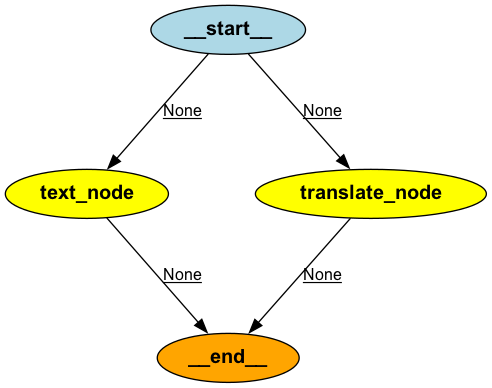

In [77]:
from IPython.display import Image, display

# Create the graph and compile the workflow
graph = create_graph()
workflow = compile_workflow(graph)
print("Graph and workflow created.")

display(Image(workflow.get_graph().draw_png()))

## 10. Executing the Workflow and Printing State Changes

In this cell, we define parameters for the workflow execution:
- `iterations`: Number of iterations to run.
- `config`: Configuration for the workflow.
- `verbose`: Flag to control the verbosity of the output.
- `dict_inputs`: Initial inputs for the workflow.
- `limit`: Recursion limit for the workflow.

We then execute the workflow asynchronously and print the state changes in different colors based on the event name.

In [78]:
# Define workflow parameters
iterations = 10
config = {"configurable": {"thread_id": "1"}}
verbose = True
dict_inputs = {"start_chain": "start"}
limit = {"recursion_limit": iterations}

# Execute the workflow and print state changes
async for event in workflow.astream_events(dict_inputs, config=config, version="v2"):

    if verbose:
        if event["name"] == "transcript_node":
            print(colored(event, "yellow"))
        elif event["name"] == "translate_node":
            print(colored(event, "green"))
        else:
            print(colored(event, "magenta"))
    else:
        print("\n")

{'event': 'on_chain_start', 'data': {'input': {'start_chain': 'start'}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'e657b5d9-307b-4793-8e10-05744cfd1ce4', 'metadata': {'thread_id': '1'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'start_chain': 'start'}}, 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'run_id': '5d9a0ce6-3565-4e26-8732-63b925fe1eba', 'metadata': {'thread_id': '1', 'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'langgraph_task_idx': 0, 'thread_ts': '1ef53531-4b09-6608-bffe-284ac6a39d33'}, 'parent_ids': ['e657b5d9-307b-4793-8e10-05744cfd1ce4']}
{'event': 'on_chain_end', 'data': {'output': {'start_chain': 'start'}, 'input': {'start_chain': 'start'}}, 'run_id': '5d9a0ce6-3565-4e26-8732-63b925fe1eba', 'name': '__start__', 'tags': ['graph:step:0', 'langsmith:hidden'], 'metadata': {'thread_id': '1', 'langgraph_step': 0, 'langgraph_node': '__start__', 'langgraph_triggers': ['__start__'], 'lang